In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score, recall_score, accuracy_score, precision_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import pickle
import os
torch.manual_seed(42)
np.random.seed(42)
base_path = '/Users/zeeshanabbasi/Desktop/internship projects/fake_news_detection'
os.makedirs(os.path.join(base_path, 'data/processed'), exist_ok=True)
os.makedirs(os.path.join(base_path, 'models'), exist_ok=True)

In [2]:
data_path = '/Users/zeeshanabbasi/Desktop/internship projects/fake_news_detection/data/archive'
try:
    fake_df = pd.read_csv(os.path.join(data_path, 'Fake.csv'))
    true_df = pd.read_csv(os.path.join(data_path, 'True.csv'))
except FileNotFoundError as e:
    print(f"Error loading datasets: {e}")
    raise
fake_df['label'] = 0
true_df['label'] = 1
df = pd.concat([fake_df, true_df], ignore_index=True)
df = df.drop(columns=['subject', 'date'])
df = df.dropna(subset=['text', 'title'])
print("Dataset shape:", df.shape)
print("Label distribution:\n", df['label'].value_counts())
print("\nFirst 5 rows:\n", df.head())

Dataset shape: (44898, 3)
Label distribution:
 label
0    23481
1    21417
Name: count, dtype: int64

First 5 rows:
                                                title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text  label  
0  Donald Trump just couldn t wish all Americans ...      0  
1  House Intelligence Committee Chairman Devin Nu...      0  
2  On Friday, it was revealed that former Milwauk...      0  
3  On Christmas day, Donald Trump announced that ...      0  
4  Pope Francis used his annual Christmas Day mes...      0  


/var/folders/03/f_3hssr15d79dbq0j2wfkkn80000gn/T/ipykernel_35499/3361532811.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set2')


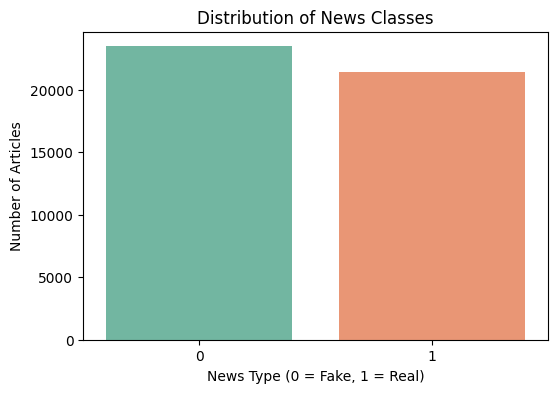

In [3]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Distribution of News Classes')
plt.xlabel('News Type (0 = Fake, 1 = Real)')
plt.ylabel('Number of Articles')
plt.show()

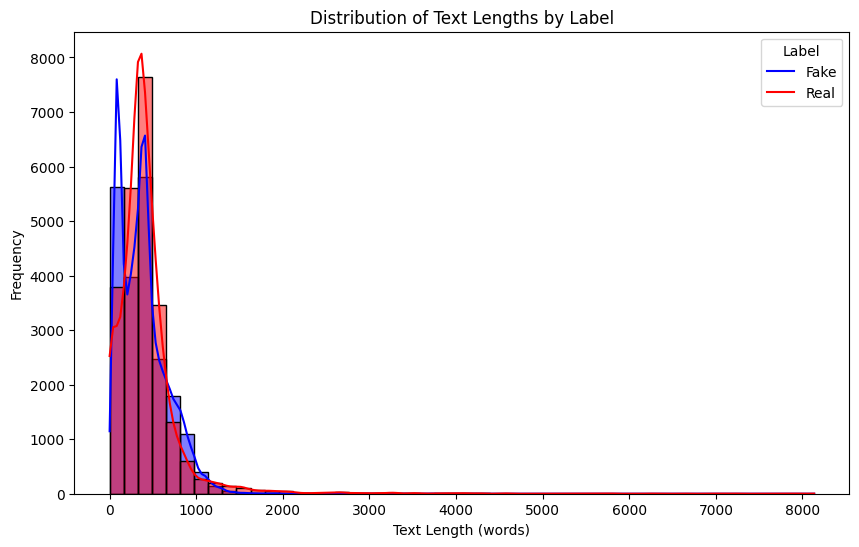

In [4]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True, palette={0: 'red', 1: 'blue'})
plt.title('Distribution of Text Lengths by Label')
plt.xlabel('Text Length (words)')
plt.ylabel('Frequency')
plt.legend(title='Label', labels=['Fake', 'Real'])
plt.show()

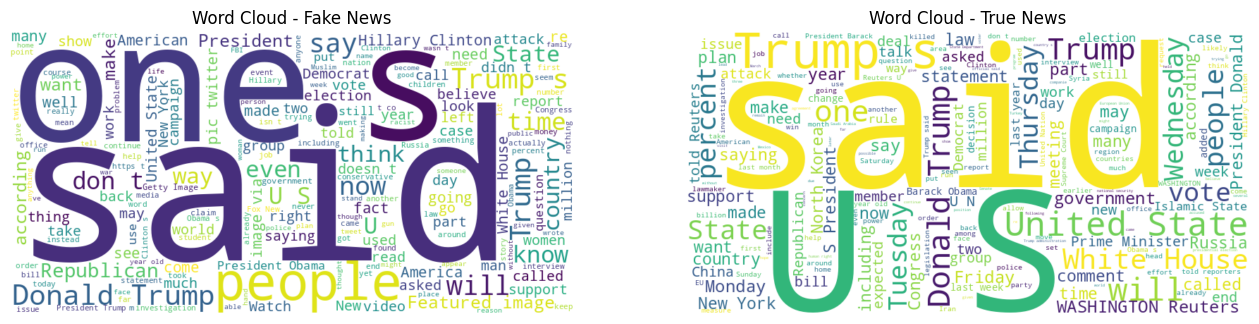

In [5]:
fake_text = ' '.join(df[df['label'] == 0]['text'])
true_text = ' '.join(df[df['label'] == 1]['text'])
fake_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
true_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(true_text)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Fake News')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - True News')
plt.axis('off')
plt.show()

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)
df['clean_text'] = df['text'].apply(preprocess_text)
try:
    df.to_csv('/Users/zeeshanabbasi/Desktop/internship projects/fake_news_detection/data/processed/cleaned_data.csv', index=False)
    print("Saved cleaned_data.csv to data/processed/")
except Exception as e:
    print(f"Error saving cleaned_data.csv: {e}")
print("Sample cleaned text:\n", df['clean_text'].head())

/var/folders/03/f_3hssr15d79dbq0j2wfkkn80000gn/T/ipykernel_35499/1254315257.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


Saved cleaned_data.csv to data/processed/
Sample cleaned text:
 0    donald trump wish american happy new year leav...
1    house intelligence committee chairman devin nu...
2    friday revealed former milwaukee sheriff david...
3    christmas day donald trump announced would bac...
4    pope francis used annual christmas day message...
Name: clean_text, dtype: object


In [7]:
all_words = ' '.join(df['clean_text']).split()
word_counts = Counter(all_words)
vocab_size = 10000
vocab = {word: i+1 for i, (word, _) in enumerate(word_counts.most_common(vocab_size))}
try:
    with open('/Users/zeeshanabbasi/Desktop/internship projects/fake_news_detection/data/processed/vocab.pkl', 'wb') as f:
        pickle.dump(vocab, f)
    print("Saved vocab.pkl to data/processed/")
except Exception as e:
    print(f"Error saving vocab.pkl: {e}")
def text_to_ids(text):
    tokens = text.split()
    ids = [vocab.get(word, 0) for word in tokens]
    return torch.tensor(ids, dtype=torch.long)
max_length = 500
padded_texts = []
for text in df['clean_text']:
    seq = text_to_ids(text)
    if len(seq) > max_length:
        seq = seq[:max_length]
    else:
        padding = torch.zeros(max_length - len(seq), dtype=torch.long)
        seq = torch.cat([seq, padding])
    padded_texts.append(seq)
padded_tensor = torch.stack(padded_texts)
labels = torch.tensor(df['label'].values)
print("Padded tensor shape:", padded_tensor.shape)

Saved vocab.pkl to data/processed/
Padded tensor shape: torch.Size([44898, 500])


In [8]:
class NewsDataset(Dataset):
    def __init__(self, texts_tensor, labels_tensor):
        self.texts = texts_tensor
        self.labels = labels_tensor
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]
dataset = NewsDataset(padded_tensor, labels)

In [9]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Training samples: 35918, Validation samples: 8980


In [10]:
class FakeNewsClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128, output_dim=2):
        super(FakeNewsClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        last_hidden = lstm_out[:, -1, :]
        out = self.dropout(last_hidden)
        out = self.fc(out)
        return out

In [11]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model = FakeNewsClassifier(vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for texts, labels in progress_bar:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    print(f"Epoch {epoch+1} Average Loss: {epoch_loss / len(train_loader):.4f}")
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")
try:
    torch.save(model.state_dict(), '/Users/zeeshanabbasi/Desktop/internship projects/fake_news_detection/models/model.pth')
    print("Saved model.pth to models/")
except Exception as e:
    print(f"Error saving model.pth: {e}")

Epoch 1/5: 100%|██████████████████| 281/281 [00:12<00:00, 22.97it/s, loss=0.679]


Epoch 1 Average Loss: 0.6910
Validation Loss: 0.6883, Accuracy: 54.21%


Epoch 2/5: 100%|████████████████████| 281/281 [00:12<00:00, 23.29it/s, loss=0.6]


Epoch 2 Average Loss: 0.6663
Validation Loss: 0.5522, Accuracy: 54.91%


Epoch 3/5: 100%|██████████████████| 281/281 [00:11<00:00, 23.51it/s, loss=0.593]


Epoch 3 Average Loss: 0.6571
Validation Loss: 0.6177, Accuracy: 65.95%


Epoch 4/5: 100%|██████████████████| 281/281 [00:11<00:00, 23.47it/s, loss=0.647]


Epoch 4 Average Loss: 0.6526
Validation Loss: 0.6611, Accuracy: 58.64%


Epoch 5/5: 100%|██████████████████| 281/281 [00:11<00:00, 23.66it/s, loss=0.672]


Epoch 5 Average Loss: 0.6501
Validation Loss: 0.6790, Accuracy: 55.43%
Saved model.pth to models/


In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print("Confusion Matrix:\n", cm)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return accuracy, f1
val_accuracy, val_f1 = evaluate_model(model, val_loader, device)
print(f"Validation Accuracy: {val_accuracy:.2%}, F1 Score: {val_f1:.4f}")

In [ ]:
def predict_fake_or_real(model, sentence, vocab, max_length=500, device='cpu'):
    model.eval()
    sentence = preprocess_text(sentence)
    tokens = sentence.split()
    token_ids = [vocab.get(word, 0) for word in tokens]
    if len(token_ids) > max_length:
        token_ids = token_ids[:max_length]
    else:
        token_ids += [0] * (max_length - len(token_ids))
    input_tensor = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        predicted = torch.argmax(output, dim=1).item()
    return "Fake" if predicted == 0 else "Real"
sentence = "The government is hiding alien technology."
result = predict_fake_or_real(model, sentence, vocab, max_length=500, device=device)
print(f"Sentence: {sentence}\nPrediction: {result}")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
X = df['clean_text']
y = df['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model_nb = make_pipeline(TfidfVectorizer(max_features=5000), MultinomialNB())
model_nb.fit(X_train, y_train)
y_pred = model_nb.predict(X_val)
cm_nb = confusion_matrix(y_val, y_pred)
accuracy_nb = accuracy_score(y_val, y_pred)
precision_nb = precision_score(y_val, y_pred, average='weighted')
recall_nb = recall_score(y_val, y_pred, average='weighted')
f1_nb = f1_score(y_val, y_pred, average='weighted')
print("Naïve Bayes Results:")
print("Confusion Matrix:\n", cm_nb)
print(f"Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(f"F1 Score: {f1_nb:.4f}")